|First Name     |Last Name    |MtkNr.      |Due Date  | 
|:-------------:|:-----------:|:----------:|:--------:|
| Giovanni    | Filomeno  |12315325     | 25.11.2024, 16:00

<h1 style="color:rgb(150,100,10)">Computer Vision Course</h1>
<h2 style="color:rgb(150,100,10)">Assignment 2 – Feature Extraction and Segmentation </h2>

<b>Authors:</b> O. Bimber, M. Abbass<br>
<b>Date:</b> 23-08-2024

<b>This file is part of the "Computer Vision Course 2024W" UE material.</b>

<h2 style="color:rgb(150,100,10)">Table of Contents</h2>
<ol>
    <a style="color:rgb(150,100,10)" href="#Feature-Extraction"><li style="font-size:large;font-weight:bold">Feature Extraction</li></a>
    <ol style="margin-bottom:15px">
        <a style="color:rgb(150,100,10)" href="#Apply-VGG-19-architecture-for-feature-extraction"><li style="font-size:medium">Apply VGG-19 architecture for feature extraction</li></a>
        <a style="color:rgb(150,100,10)" href="#Apply-ResNet-152-architecture-for-feature-extraction"><li style="font-size:medium">Apply ResNet-152 architecture for feature extraction</li></a>
    </ol>
    <a style="color:rgb(150,100,10)" href="#Segmentation"><li style="font-size:large;font-weight:bold">Segmentation </li></a>
    <ol style="margin-bottom:15px">
        <a style="color:rgb(150,100,10)" href="#Preparation-the-dataset-and-our-environment"><li style="font-size:medium">Preparing the dataset and our environment</li></a>
        <a style="color:rgb(150,100,10)" href="#Apply-Yolov8-for-crack-segmentation"><li style="font-size:medium">Apply Yolov8 for crack segmentation</li></a>
    </ol>
</ol>


<h1 style="color:rgb(255,0,0)">Important Note</h1>

<b>In this assignment, you can use the default parameters in any built-in function unless specified otherwise.</b>

<b>All cells must be evaluated, and any unevaluated cell may lead to a loss of points, regardless of the correctness of the code.</b>

<b>If you have GPU resources available on your machine, please utilize them; otherwise, you can use your CPU.</b>

<b>Always set the seed value to 123 unless specified otherwise.</b>

In [1]:
# Import all packages needed in this notebook.
import numpy as np
import cv2 as cv
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.models.resnet import resnet152
from torchvision.models.vgg import vgg19
from torchvision.models import VGG19_Weights, ResNet152_Weights
from torchvision.transforms import functional as F
import torch
import os
import glob
from sklearn.model_selection import train_test_split
import shutil
import wget

if not os.path.exists('resources'): raise TypeError("Please create the resources folder and include all required files")

<a name="Feature-Extraction"></a><h2> Feature Extraction</h2>    
In this assignment, we use two popular architectures: <i><b>Vgg19</b><i> and <i><b>ResNet-152</b><i>. 

<span style="color:rgb(200,100,10)">The reference paper can be found [at this link](https://arxiv.org/pdf/1512.03385)</span>.    
    
We start by reading the color <i><b>veh2</b><i> image and then convert it to a tensor with four dimensions <i><b>(batch x channel x height x width)</b><i> using the provided function <i><b>read_Img_Torch</b><i>. The <i><b>batch size</b><i> here is equal to one.

In [2]:
def read_Img_Torch(input_img, using_Cuda :bool = False):
    
    if type(input_img) != str:
        raise ValueError("input must be string)")
        
    img_Orig = Image.open(input_img)
    image_np = np.array(img_Orig)/255.0
    
    if image_np.ndim != 3:
        raise ValueError("input image must have 3 channels)")
    image_np = np.transpose(image_np, (2, 0, 1))
    
    if using_Cuda:
        return torch.tensor(image_np, dtype=torch.float32).cuda().unsqueeze(0).float()
    else:
        return torch.tensor(image_np, dtype=torch.float32).unsqueeze(0).float()
            

Let's display both the shape of the image tensor and the image itself.

torch.Size([1, 3, 333, 442])


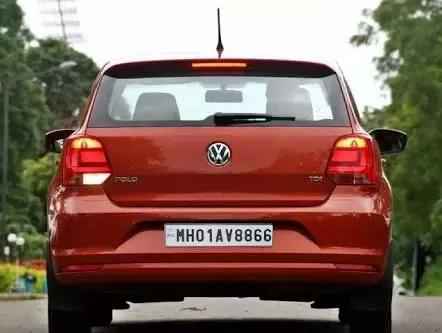

In [3]:
img_input = read_Img_Torch("resources/veh2.jpg")

print(img_input.shape)
F.to_pil_image(img_input[0])

<a name="Apply-VGG-19-architecture-for-feature-extraction"></a><h3>Apply VGG-19 architecture for feature extraction</h3>

<b>Exercise 1.1. [8 Points]</b>

<b>Goal:</b> In this section, the aim is to observe the differences between spatial details and semantics by utilizing the popular architecture <i><b>Vgg19</b><i>. We will extract different feature maps from several layers.

<b>Task</b>
<ul>
<li>Extract <i><b>10</b><i> feature maps from the following layers: <i><b>Conv 1-1, Conv 1-2, Conv 2-1, Conv 2-2, Conv 3-1, Conv 3-2, Conv 3-3, Conv 3-4, Conv 4-1, Conv 4-2</b><i>.</li>
<li>For simplicity let's use numbers to refer to the convolutional layers as follows: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 to represent feature maps of Conv 1-1, Conv 1-2, Conv 2-1, Conv 2-2, Conv 3-1, Conv 3-2, Conv 3-3, Conv 3-4, Conv 4-1, Conv 4-2, respectively.</li>
</ul>

        
<b>Hint</b>
<ul>
<li>Use the <i><b>Feat_Extr_Vgg</b><i> function to extract the features of interest.</li>
<li>Apply the tensor output from the <i><b>read_Img_Torch</b><i> function from above, which converts the color <i><b>veh2</b><i> image to a tensor.</li>
</ul>

In [4]:
def Feat_Extr_Vgg(image_ip, layer_no, using_Cuda :bool = False):
    outputs = {}
    def activation(name):
        def hook(module, input, output):
            outputs[name] = output.detach()
        return hook
    
    if using_Cuda: model = vgg19(weights=VGG19_Weights.DEFAULT).cuda()
    else:
        model = vgg19(weights=VGG19_Weights.DEFAULT)
                
        
   
    if layer_no in range(0,2):
        if layer_no == 0: model.features[0].register_forward_hook(activation('layer1'))
        elif layer_no == 1: model.features[2].register_forward_hook(activation('layer1'))
        
    elif layer_no in range(2,4):
        if layer_no == 2: model.features[5].register_forward_hook(activation('layer1'))
        elif layer_no == 3: model.features[7].register_forward_hook(activation('layer1'))
            
    elif layer_no in range(4,8):
        if layer_no == 4: model.features[10].register_forward_hook(activation('layer1'))
        elif layer_no == 5: model.features[12].register_forward_hook(activation('layer1'))
        elif layer_no == 6: model.features[14].register_forward_hook(activation('layer1'))
        elif layer_no == 7: model.features[16].register_forward_hook(activation('layer1'))
        
    
    elif layer_no in range(8,12):
        if layer_no == 8: model.features[19].register_forward_hook(activation('layer1'))
        elif layer_no == 9: model.features[21].register_forward_hook(activation('layer1'))
        elif layer_no == 10: model.features[23].register_forward_hook(activation('layer1'))
        elif layer_no == 11: model.features[25].register_forward_hook(activation('layer1'))
        
    
    elif layer_no in range(12,15):
        if layer_no == 12: model.features[28].register_forward_hook(activation('layer1'))
        elif layer_no == 13: model.features[30].register_forward_hook(activation('layer1'))
        elif layer_no == 14: model.features[32].register_forward_hook(activation('layer1'))
        elif layer_no == 15: model.features[34].register_forward_hook(activation('layer1'))
            
    else:
        raise ValueError("This layer isn't present")   
             
    
    vis = model(image_ip)
    feature_map = outputs['layer1'].detach().cpu().squeeze(0) # 128x128x64


    feature_map = abs(feature_map)
    gray_scale = torch.sum(feature_map,0) # 128x128x1
    processed_features = (gray_scale - gray_scale.min()) / (gray_scale.max() - gray_scale.min())  # Normalize feature map
    
    
    features_Numpy = processed_features.numpy()
    return features_Numpy


In [5]:
# The code goes here

feature_maps_vgg = []  
for i in range(10):  # --> loop from 0 to 9
    feature_map_vgg = Feat_Extr_Vgg(image_ip=img_input, layer_no=i)
    feature_maps_vgg.append(feature_map_vgg)


<b>Exercise 1.2. [8 Points]</b>

<b>Goal:</b> Since all feature maps have different sizes, let's resize all feature maps to a uniform size.

<b>Task</b>
<ul>
<li>Resize all feature maps from <i><b>Exercise 1.1.</b><i> to a size of $300 \times 300$.</li>
<li>You need to use <i><b>bicubic interpolation</b><i>.</li>
</ul>

        
<b>Hint</b>
<ul>
<li>Use OpenCV's built-in <i><b>resize</b><i> function to resize the feature maps.</li>
</ul>

In [6]:
# The code goes here

resized_feature_maps_vgg = []
for feature_map in feature_maps_vgg:
    resized_vgg = cv.resize(src=feature_map, dsize=(300, 300), interpolation=cv.INTER_CUBIC)
    resized_feature_maps_vgg.append(resized_vgg)


<b>Exercise 1.3. [7 Points]</b>

<b>Goal: </b> Now, let's display all our feature maps.

<b>Task</b>
<ul>
<li>Display all the results from <i><b>Exercise 1.2</b><i> in a grid with <i><b>2 rows</b><i> and <i><b>5 columns</b><i> in ascending order. </li>
</ul>

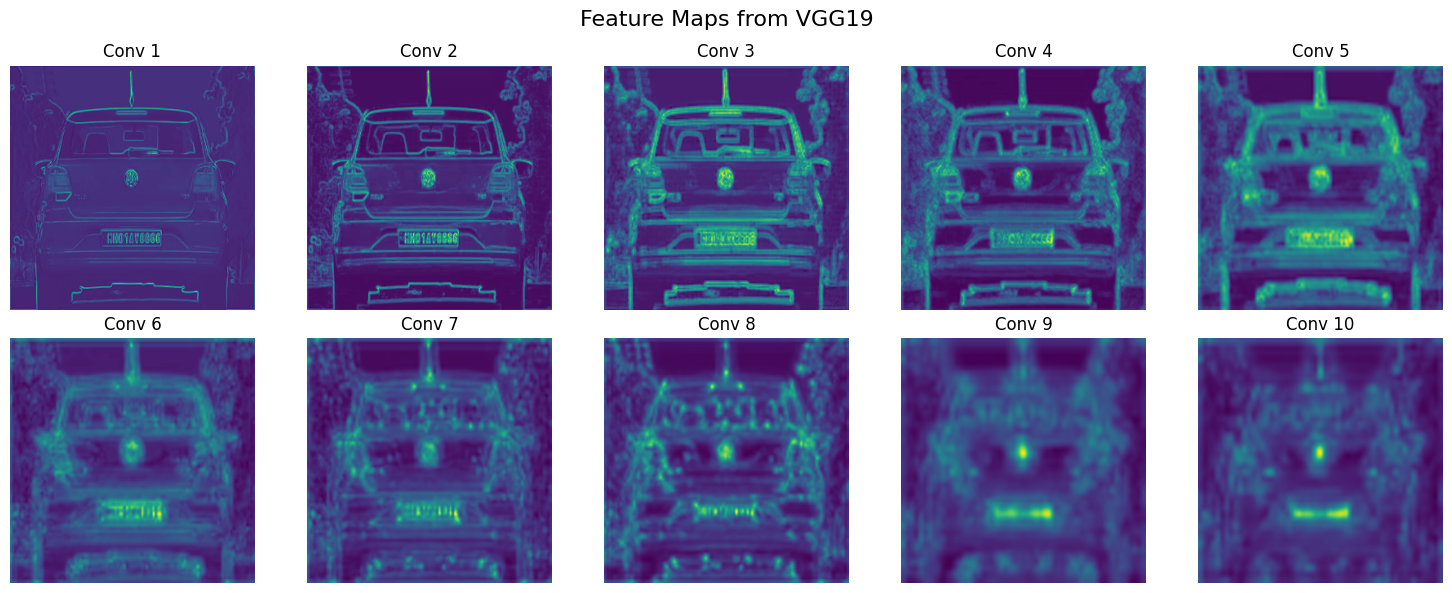

In [7]:
# The code goes here

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Feature Maps from VGG19", fontsize=16)

axes = axes.ravel()

for i in range(10):  
    axes[i].imshow(resized_feature_maps_vgg[i])
    axes[i].set_title(f"Conv {i+1}")  
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

<a name="Apply-ResNet-152-architecture-for-feature-extraction"></a><h3>Apply ResNet-152 architecture for feature extraction</h3>

<b>Exercise 1.4. [8 Points]</b>

<b>Goal:</b> Let's explore another popular architecture, <i><b>ResNet-152</b><i>, to extract multiple feature maps. The aim is also to observe the differences between spatial details and semantics in <i><b>ResNet-152</b><i>. In <i><b>ResNet-152</b><i>, there are more several layers with <i><b>residual connections</b><i>. 

<b>Task</b>
<ul>
<li>Extract <i><b>10</b></i> feature maps from the first 10 convolutional layers.</li>
<li>For simplicity also let's use numbers to refer to the first ten convolutional layers as follows: <i><b>0, 1, 2, 3, 4, 5, 6, 7, 8, 9</b><i>
</ul>
    
        
<b>Hint</b>
<ul>
<li>Use the <i><b>Feat_Extraction_ResNet</b><i> function to extract the features of interest.</li>
<li>Apply the tensor output from the <i><b>read_Img_Torch</b><i> function using the color <i><b>veh2</b><i> image mentioned earlier.</li>
</ul>

In [8]:
def Feat_Extr_ResNet152(image_ip, layer_no, using_Cuda :bool = False):
    outputs = {}
    def activation(name):
        def hook(module, input, output):
            outputs[name] = output.detach()
        return hook
    
    if using_Cuda: model = resnet152(weights = ResNet152_Weights.DEFAULT).cuda()
    else:
        model = resnet152(weights = ResNet152_Weights.DEFAULT)
    
    
    if layer_no == 0: model.conv1.register_forward_hook(activation('layer1'))
        
    elif layer_no == 1: model.layer1[0].conv1.register_forward_hook(activation('layer1'))
    elif layer_no == 2: model.layer1[0].conv2.register_forward_hook(activation('layer1'))    
    elif layer_no == 3: model.layer1[0].conv3.register_forward_hook(activation('layer1')) 


    
    elif layer_no == 4: model.layer1[1].conv1.register_forward_hook(activation('layer1'))
    elif layer_no == 5: model.layer1[1].conv2.register_forward_hook(activation('layer1'))   
    elif layer_no == 6: model.layer1[1].conv3.register_forward_hook(activation('layer1'))
   
    elif layer_no == 7: model.layer1[2].conv1.register_forward_hook(activation('layer1'))
    elif layer_no == 8: model.layer1[2].conv2.register_forward_hook(activation('layer1'))   
    elif layer_no == 9: model.layer1[2].conv3.register_forward_hook(activation('layer1'))
        
        
    else:
        raise ValueError("The number of layer should be integer and between 0 and 34")
    
   
    vis_ = model(image_ip)

    feature_map = outputs['layer1'].detach().cpu().squeeze(0) # 128x128x64


    feature_map = abs(feature_map)
    gray_scale = torch.sum(feature_map,0) # 128x128x1
    processed_features = (gray_scale - gray_scale.min()) / (gray_scale.max() - gray_scale.min())  # Normalize feature map
    
    
    features_Numpy = processed_features.numpy()
    return features_Numpy


In [9]:
# The code goes here

feature_maps_resnet = []

for i in range(10):
    feature_map_resnet = Feat_Extr_ResNet152(image_ip=img_input, layer_no=i)
    feature_maps_resnet.append(feature_map_resnet)

<b>Exercise 1.5. [8 Points]</b>

<b>Goal:</b> Since all feature maps have varying sizes, let's resize all feature maps to a consistent size.

<b>Task</b>
<ul>
<li>Resize all feature maps from <i><b>Exercise 1.4.</b><i> to be $300 \times 300$.</li>
<li>You need to use <i><b>bicubic interpolation</b><i>.</li>
</ul>

        
<b>Hint</b>
<ul>
<li>Use OpenCV's built-in <i><b>resize</b><i> function to resize the feature maps.</li>
</ul>

In [10]:
# The code goes here

resized_feature_maps_resnet = []

for feature_map in feature_maps_resnet:
    resized_resnet = cv.resize(src=feature_map, dsize=(300, 300), interpolation=cv.INTER_CUBIC)
    resized_feature_maps_resnet.append(resized_resnet)


<b>Exercise 1.6. [7 Points]</b>

<b>Goal:</b> Now, let's display all our feature maps from the <i><b>ResNet-152</b><i> architecture.

<b>Task</b>
<ul>
<li>Display all the results from <i><b>Exercise 1.5.</b><i> in a grid with <i><b>2 rows</b><i> and <i><b>5 columns</b><i>.
</ul>

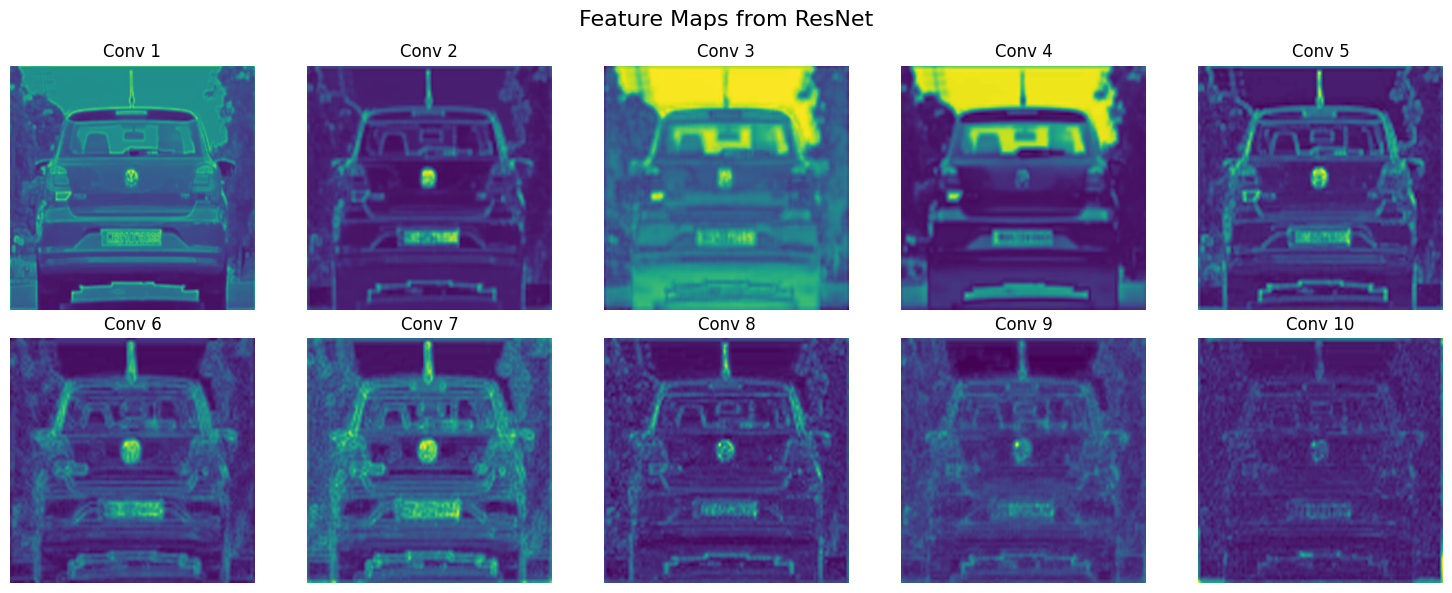

In [11]:
# The code goes here

# The code goes here

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Feature Maps from ResNet", fontsize=16)

axes = axes.ravel()

for i in range(10):  
    axes[i].imshow(resized_feature_maps_resnet[i])
    axes[i].set_title(f"Conv {i+1}")  
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

<b>Exercise 1.7. [4 Points]</b>

<b>Question</b>
<ul>
<li>Based on the figures shown in both <i><b>Exercises 1.3 and 1.6</b></i>, why do you think ResNet-152 achieves better performance as network depth increases?</li> 
</ul>

<b>Hint</b>
<ul>
<li>You can focus on the comparison between spatial details and semantics, particularly in the deeper layers, such as <i><b>layers 8 and 9</b></i>.</li>   
</ul>

The explanation goes here:

ResNet-152 outperforms VGG19 in deeper layers by capturing richer semantic representations (e.g., the car's details remain visible in ResNet's layer 9, while they largely disappear in VGG19). This is due to the vanishing gradient problem in VGG19, which makes training deeper layers more difficult. Additionally, ResNet-152 preserves spatial details in deeper layers by combining initial features with abstract ones, leading to better performance


<a name="Segmentation"></a><h2> Segmentation</h2>

In the second part, we utilize one of the most popular techniques in image segmentation: <i><b>YOLOv8</b></i>.

<span style="color:rgb(200,100,10)">More details can be found [at this link](https://docs.ultralytics.com/models/yolov8/)</span>.
    

<b>The main goal in this part can be broken down into three sub-goals as follows:</b>
<ul>
<li>Split the data into three parts (train, test, validation).</li>    
<li>Train YOLO to segment our objects.</li>
<li>Test our trained model using the test subset.</li>
</ul>

<h3 style="color:rgb(255,0,0)">Important Note</h3>
<span style="color:rgb(200,0,10)">When you start invoking YOLO commands, a folder called <i><b>runs</b></i> is generated automatically.</span>.

<b>Before diving into YOLO, let's complete a couple of steps as follows:</b>
<ul> 
<li>We need to import YOLO. Therefore, we need to install the <i><b>ultralytics</b></i> package using this command: <i><b>pip install ultralytics</b></i></li> 
<li>Download the pre-trained model instead of training from scratch.</li> 

In [12]:
from ultralytics import YOLO
model = YOLO('yolov8n-seg.pt')  # load a pretrained model

We use a dataset containing one class, which is: <span style="color:rgb(200,0,200)">crack</span>. <span style="color:rgb(200,100,10)">More details about our dataset can be found at [this link](https://docs.ultralytics.com/datasets/segment/crack-seg/#sample-data-and-annotations)</span>.

<b>Some information about the data:</b> The dataset comprises a diverse collection of images captured across various locations, environments, and densities, making it a comprehensive resource for developing models tailored to crack segmentation. It includes a total of 4,029 static images captured in different road and wall scenarios.

<a name="Here is the example of crack segmentation"></a><h3 style="color:rgb(100,0,200)">Here is the example of crack segmentation from the site of [ultralytics](https://docs.ultralytics.com/datasets/segment/crack-seg/#sample-data-and-annotations)</h3>
<img src="resources/Example_Crack.jpg" alt="Image not found!"/>

<h1 style="color:rgb(150,75,0)">Let's work on our dataset and its preparation:</h1>
<ul> <li><span style="color:rgb(200,10,10)">The dataset, named <i><b>crack-seg-A2</b></i>, is zipped on Google Drive and contains two subfolders: images and labels.</span>
    
<span style="color:rgb(200,10,10)">The Google Drive link is: [Here](https://drive.google.com/file/d/1O0QWCqgETup_VHhABL4l6vvm__4K4Nr4/view?usp=sharing).</span> </li>
<li><span style="color:rgb(200,10,10)">The YAML file named <i><b>data_A2</b></i> is also in the resources folder.</span></li> </ul>

<a name="Preparation-the-dataset-and-our-environment"></a><h3>Preparing the dataset and our environment</h3>

<b>Exercise 2.1. [10 Points]</b>

<b>Goal:</b> Let's prepare our custom dataset by splitting it into three subsets: test, train, and validation.

<b>Task</b>
<ul>
<li>Split the data into test, train, and validation subsets with the following ratios: 5%, 80%, and 15%, respectively.<i>
<li>You need to use the <i><b>train_test_split</b></i> function with the seed set to <i><b>123</b></i> in all cases.</li> 
<li>The seed for the global random number generator must be set to <i><b>123</b></i> to ensure reproducible results. Use the <i><b>random_state</b></i> parameter in the <i><b>train_test_split</b></i> function.</li> 
</ul>

<b>Hint</b>
<ul>
<li>The <i><b>train_test_split</b></i> function is part of the <i><b>sklearn.model_selection</b></i>.</li> 
<li>You must <i><b>unzip</b></i> the dataset folder <i><b>crack-seg-A2</b></i> and the keep this unzipped folder in the resources folder as well.</li>
<li>To read all <i><b>.jpg</b></i> images and <i><b>.txt</b></i> files, you can use <i><b>glob</b></i> from the glob library.</li>
<li>To sort all images and .txt files based in ascending order, you can use the <i><b>sorted</b><i> function, a built-in Python function.</li>

</ul>

In [13]:
# The code goes here
import glob 
import os

image_files = sorted(glob.glob(os.path.join("resources/crack-seg-A2/images", "*.jpg")))
label_files = sorted(glob.glob(os.path.join("resources/crack-seg-A2/labels", "*.txt")))

images_train_val, images_test, labels_train_val, labels_test = train_test_split(
    image_files, label_files, test_size=0.05, random_state=123
)

images_train, images_val, labels_train, labels_val = train_test_split(
    images_train_val, labels_train_val, test_size=0.15789, random_state=123 
)

print(f"Len of the original dataset: {len(image_files)}")
print(f"Len of the train: {len(images_train)} ({int(100*len(images_train)/len(image_files))})")
print(f"Len of the test: {len(images_val)} ({int(100*len(images_val)/len(image_files))})")
print(f"Len of the val: {len(images_test)} ({int(100*len(images_test)/len(image_files))})")

Len of the original dataset: 4029
Len of the train: 3222 (79)
Len of the test: 605 (15)
Len of the val: 202 (5)


<b>Exercise 2.2. [6 Points]</b>

<b>Goal:</b> Let's save each subset in the corresponding folder. Afterwards, YOLO should use these folders for training. 
<span style="color:rgb(200,10,10)">The 'test', 'train', and 'valid' subsets are saved in the 'test', 'train', and 'valid' folders, respectively, under the folder 'data_seg_A2', inside the 'resources' folder.</span>


<b>Task</b>

<ul> <li>Save the test, training, and validation subsets in their corresponding folders.</li> <li>Use the <i><b>copy_img_label</b></i> function to save both the images and labels to the appropriate folders. You must use a string <i><b>(lowercase or uppercase, both are fine)</b></i> to indicate the subfolder as follows: <i><b>'test'</b></i>, <i><b>'train'</b></i>, or <i><b>'valid'</b></i> for the test folder, train folder, and valid folder, respectively.</li> </ul>
<b>Hint</b>

<ul>
<li>The function <i><b>create_folders</b></i> provided below should create the <i><b>data_seg_A2</b></i> folder along with the subfolders for <i><b>'test', 'train', and 'valid'</b></i></li>
<li>The function <i><b>copy_img_label</b></i> provided below should copy all images and corresponding labels to the associated subfolders: <i><b>‘test’, ‘train’, and ‘valid’</b></i>.</li>
<li>Lowercase or uppercase letters are both acceptable to indicate the folder of interest (test folder, train folder, valid folder).</li> </ul>

In [14]:
def create_folders():
    if not os.path.exists('resources/data_seg_A2'): os.mkdir('resources/data_seg_A2') 
    if not os.path.exists('resources/data_seg_A2/test'): os.mkdir('resources/data_seg_A2/test') 
    if not os.path.exists('resources/data_seg_A2/train'): os.mkdir('resources/data_seg_A2/train') 
    if not os.path.exists('resources/data_seg_A2/valid'): os.mkdir('resources/data_seg_A2/valid') 

    # images
    if not os.path.exists('resources/data_seg_A2/test/images'): os.mkdir('resources/data_seg_A2/test/images') 
    if not os.path.exists('resources/data_seg_A2/train/images'): os.mkdir('resources/data_seg_A2/train/images') 
    if not os.path.exists('resources/data_seg_A2/valid/images'): os.mkdir('resources/data_seg_A2/valid/images')
   
    # labels
    if not os.path.exists('resources/data_seg_A2/test/labels'): os.mkdir('resources/data_seg_A2/test/labels') 
    if not os.path.exists('resources/data_seg_A2/train/labels'): os.mkdir('resources/data_seg_A2/train/labels') 
    if not os.path.exists('resources/data_seg_A2/valid/labels'): os.mkdir('resources/data_seg_A2/valid/labels')
    

In [15]:
def copy_img_label(image_files, label_files, type_file : str):
    create_folders()
    
    if type_file.lower() == 'test':
        for img_files, lab_files in zip (image_files, label_files):
            shutil.copy2(img_files, 'resources/data_seg_A2/test/images/')
            shutil.copy2(lab_files, 'resources/data_seg_A2/test/labels/')

    elif type_file.lower() == 'train':
        for img_files, lab_files in zip (image_files, label_files):
            shutil.copy2(img_files, 'resources/data_seg_A2/train/images/')
            shutil.copy2(lab_files, 'resources/data_seg_A2/train/labels/')
            
    elif type_file.lower() == 'valid':
        for img_files, lab_files in zip (image_files, label_files):
            shutil.copy2(img_files, 'resources/data_seg_A2/valid/images/')
            shutil.copy2(lab_files, 'resources/data_seg_A2/valid/labels/')
    else:
        raise ValueError("The string should be 'test', 'train', 'valid'") 

In [16]:
# The code goes here

create_folders()

copy_img_label(images_train, labels_train, 'train')

copy_img_label(images_val, labels_val, 'valid')

copy_img_label(images_test, labels_test, 'test')

<a name="Apply-Yolov8-for-crack-segmentation"></a><h3>Apply Yolov8 for crack segmentation</h3>

<b>Exercise 2.3. [10 Points]</b>

<b>Goal:</b> Let's train the YOLO on a custom dataset.

<b>Task</b>
<ul>
<li>Train YOLO using the following parameters: <i><b>batch=16</b><i>, <i><b>number of epochs=10</b><i>, <i><b>seed=123</b><i>, <i><b>image size=320</b><i> 

<span style="color:rgb(200,10,10)">More details about training YOLOv8 can be found at [this link](https://docs.ultralytics.com/models/yolov8/#how-can-i-use-yolov8-for-different-computer-vision-tasks)</span><i>.

<li>Please carefully read the <i><b>Hint</b></i> section below to correctly set up the data path.</li>
</ul>

<b>Hint</b>
<ul>
<li>Open the <i><b>YAML</b></i> file located at <i><b>resources\data_A2.yaml</b></i> and update the <i><b>path</b><i>.</li>    
<li>Ensure that you update the path in the <i><b>data_A2.yaml</b></i> file to match your full absolute path. For example, my absolute path is <i><b>C:/Users/myehia/Desktop/Computer_Vision/assignment_2/resources/data_seg_A2</b></i>. <span style="color:rgb(220,0,0)">Therefore, you need to use your own absolute path.</span></li>
    
<li><span style="color:rgb(200,10,10)">Please note that the <i><b>training</b></i> can take more than 45 minutes with a GPU and up to a day without a GPU (using a CPU).</span></li> </ul>
</ul>

In [17]:
# The code goes here

import torch
torch.manual_seed(123)

data_yaml = "/Users/giovannifilomeno/Desktop/Computer Vision/resources/data_A2.yaml"

model = YOLO("yolov8n-seg.pt")

model.train(
    data=data_yaml,      
    epochs=10,              
    batch=16,              
    imgsz=320,            
    device="cpu"       
)

Ultralytics 8.3.36 🚀 Python-3.11.10 torch-2.5.1 CPU (Apple M4 Pro)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/Users/giovannifilomeno/Desktop/Computer Vision/resources/data_A2.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

train: Scanning /Users/giovannifilomeno/Desktop/Computer Vision/resources/data_seg_A2/train/labels.cache... 3222 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3222/3222 [00:00<?, ?it/s]
val: Scanning /Users/giovannifilomeno/Desktop/Computer Vision/resources/data_seg_A2/valid/labels.cache... 605 images, 0 backgrounds, 0 corrupt: 100%|██████████| 605/605 [00:00<?, ?it/s]

Plotting labels to runs/segment/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/segment/train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.519        1.7      1.837      1.337          9        320: 100%|██████████| 202/202 [05:09<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:31<00:00,  1.63s/it]

                   all        605        814      0.656      0.541      0.535      0.284      0.482      0.426      0.314     0.0733



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.504      1.377      1.575      1.299          6        320: 100%|██████████| 202/202 [1:07:06<00:00, 19.93s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:45<00:00,  2.37s/it]

                   all        605        814      0.693      0.517      0.521      0.263        0.6      0.465      0.414      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.456      1.359      1.475      1.278          6        320: 100%|██████████| 202/202 [1:26:47<00:00, 25.78s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [15:56<00:00, 50.36s/it] 

                   all        605        814      0.712      0.559      0.543      0.317      0.606      0.483       0.42      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.358      1.323      1.344       1.23          7        320: 100%|██████████| 202/202 [1:11:58<00:00, 21.38s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [16:11<00:00, 51.15s/it]  

                   all        605        814      0.742      0.602      0.621      0.389      0.684      0.555      0.537      0.165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.239      1.291      1.238      1.181          8        320: 100%|██████████| 202/202 [2:01:35<00:00, 36.12s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [17:10<00:00, 54.25s/it] 

                   all        605        814      0.744      0.618      0.629      0.405      0.635      0.543      0.477      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.148      1.265      1.142      1.152          7        320: 100%|██████████| 202/202 [1:45:18<00:00, 31.28s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [16:06<00:00, 50.87s/it]  

                   all        605        814      0.782      0.607      0.644      0.406      0.699      0.563      0.543      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.063      1.225      1.064      1.118          9        320: 100%|██████████| 202/202 [1:48:26<00:00, 32.21s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:47<00:00,  8.83s/it]

                   all        605        814      0.816      0.623      0.672      0.462      0.723      0.577      0.546      0.171



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.9981      1.182      1.005      1.096          7        320: 100%|██████████| 202/202 [1:39:45<00:00, 29.63s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [18:31<00:00, 58.48s/it] 

                   all        605        814      0.822      0.634      0.674      0.471      0.749      0.578      0.551      0.172

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       9/10         0G     0.9374      1.157     0.9511      1.076          9        320: 100%|██████████| 202/202 [1:40:58<00:00, 29.99s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:43<00:00,  8.60s/it]

                   all        605        814      0.788      0.655      0.694      0.501      0.779      0.587      0.616        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.8791      1.138     0.8985      1.065          9        320: 100%|██████████| 202/202 [1:55:35<00:00, 34.33s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:30<00:00,  1.59s/it]

                   all        605        814      0.795      0.664      0.715      0.535      0.756      0.624      0.642      0.216

10 epochs completed in 16.233 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.7MB


Optimizer stripped from runs/segment/train/weights/best.pt, 6.7MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.11.10 torch-2.5.1 CPU (Apple M4 Pro)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:28<00:00,  1.50s/it]


                   all        605        814      0.796      0.667      0.715      0.535      0.756      0.624      0.641      0.217
Speed: 0.1ms preprocess, 43.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x3659b0b50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

<b>Exercise 2.4. [10 Points]</b>

<b>Goal:</b> Now, we can exploit the trained model to predict and segment the <i><b>cracks</b><i> using <i><b>unseen data from the test subset</b><i>.

<b>Task</b>
<ul>
<li>Load the trained parameters <i><b>best.pt</b><i><i>.
<li>Use this <i><b>best.pt</b><i> to predict the <i><b>first 20</b><i> images in the test folder: <i><b>resources/data_seg_A2/test/images</b><i>
<li>You need to save the results by setting <i><b>save=True</b><i><i>.
<li>Since we didn't train for enough epochs, set the confidence to <i><b>conf=0.1</b><i><i>.
</ul>
    
<b>Hint</b>
<ul>
<li>Assuming you have only <i><b>one train folder</b><i>, the <i><b>best.pt</b><i> weight is in the following folder: <i><b>runs/segment/train/weights</b><i> </li>
<li>The results are saved in the following folder: <i><b>runs/segment/predict</b><i> </li>
<li>Write all the intended images into a list and provide them to the model at once.</li>
<li>To read all <i><b>.jpg</b><i> images, you can use <i><b>glob</b><i> from the glob library </li> 
<li>To sort all images in ascending order, you can use <i><b>sorted</b><i> from the Python built-in functions.</li>
</ul>

In [21]:
# The code goes here
best_model_path = "runs/segment/train/weights/best.pt"
best_model = YOLO(best_model_path)

test_image_dir = "resources/data_seg_A2/test/images"
all_test_images = sorted(glob.glob(os.path.join(test_image_dir, "*.jpg")))
first_20_images = all_test_images[:20]

results = best_model.predict(
    source=first_20_images,  
    save=True,               
    conf=0.1                 
)



0: 320x320 4 cracks, 37.3ms
1: 320x320 1 crack, 37.3ms
2: 320x320 3 cracks, 37.3ms
3: 320x320 3 cracks, 37.3ms
4: 320x320 3 cracks, 37.3ms
5: 320x320 1 crack, 37.3ms
6: 320x320 2 cracks, 37.3ms
7: 320x320 3 cracks, 37.3ms
8: 320x320 5 cracks, 37.3ms
9: 320x320 1 crack, 37.3ms
10: 320x320 1 crack, 37.3ms
11: 320x320 4 cracks, 37.3ms
12: 320x320 4 cracks, 37.3ms
13: 320x320 1 crack, 37.3ms
14: 320x320 1 crack, 37.3ms
15: 320x320 1 crack, 37.3ms
16: 320x320 1 crack, 37.3ms
17: 320x320 8 cracks, 37.3ms
18: 320x320 3 cracks, 37.3ms
19: 320x320 1 crack, 37.3ms
Speed: 0.3ms preprocess, 37.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/segment/predict


<b>Exercise 2.5. [6 Points]</b>

<b>Goal:</b> Let's show some results.

<b>Task</b>
<ul>
<li>From the results in <i><b>runs/segment/predict</b><i>, please show the first <i><b>8</b><i> image results in a grid with <i><b>2 rows</b><i> and <i><b>4 columns</b><i>.
</ul>
    
    
<b>Hint</b>
<ul>
<li>Assuming you have only <i><b>one predict folder</b><i>, the results are saved in the following folder: <i><b>runs/segment/predict</b><i> </li>
</ul>

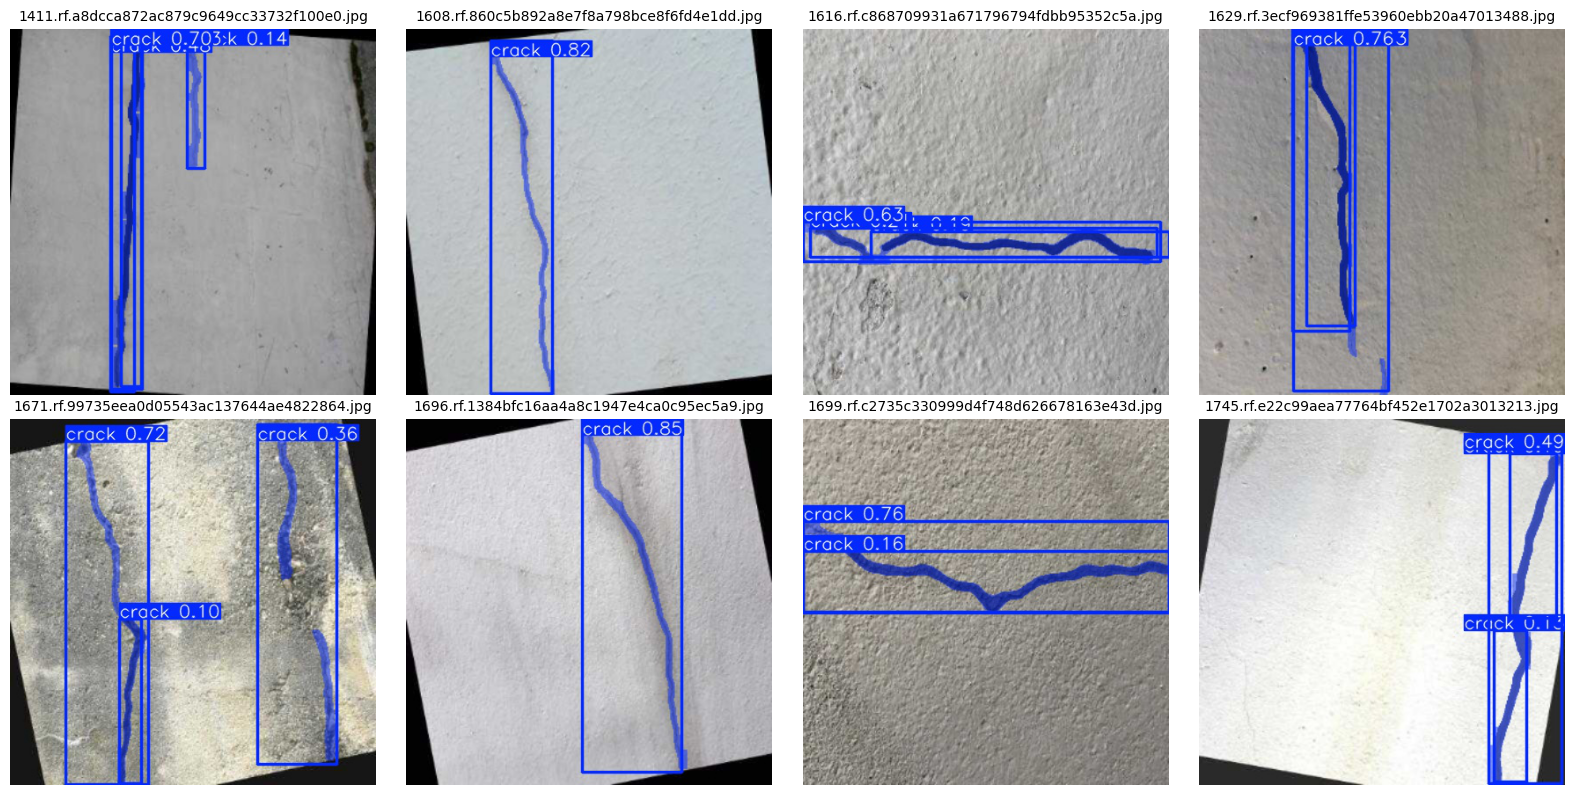

In [22]:
# The code goes here

predict_dir = "runs/segment/predict"

image_files = glob.glob(os.path.join(predict_dir, '*.jpg'))

image_files = sorted(image_files)

first_8_images = image_files[:8]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes = axes.flatten()

for img_path, ax in zip(first_8_images, axes):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(os.path.basename(img_path), fontsize=10)

for ax in axes[len(first_8_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

<b>Exercise 2.6. [8 Points]</b>


<b>Question</b>

<b>Here, we have two questions:</b>
<ul>
<li>How can we improve the confidence score?</li>
<li>As shown in the first image (row 1, column 1), how can we suppress and reduce multiple classifications for a single object?</li> 
</ul>

The explanation goes here:

1) We can have two strategies: model and data. 
Regarding the model, to improve the confidence score we can train for more epochs. More epochs would increase the features understing of the model. Additionally, a fine tune of the box will improve the predictions for cracks. 
Regarding the data, we can increase the dataset size. Using a larger dataset will increase the robustness of the learning. Additionally, we can also use augmentation (for example flipping, scaling, rotation, etc.) that can help the geralization of the model. 

2) One strategy could be intersection over union parameter in the predict function (default=0.7), in this case the overlapping boxes with lower confidence are suppressed. We could increase the confidence treshold (from exercise 0.1) which can eliminate low-confidence predictions reducing duplicates in classifications. Last but not least, a post-processing function can be implemented to adjust such cases.
